In [1]:
## Part 1:
##select the best way for datapreprocess
import pandas as pd
df = pd.read_csv("data/data_1920_2_3.csv")
df.head()

,Unnamed: 0,Y,Weight,RATCAT_A,INCTCFLG_A,FAMINCTC_A,PPSU,DISAB3_A,LEGMSTAT_A,MARSTAT_A,...,DIBEV_A,PREDIB_A,CANEV_A,ASEV_A,STREV_A,ANGEV_A,CHLEV_A,HYPEV_A,AVAIL_A,INTV_QRT
0,1,0.000000,13177.008,9,0,60000,2,2,3,1,...,2,2,2,2,2,2,1,2,1,1
1,2,0.000000,6140.552,9,0,50000,2,2,3,1,...,2,2,2,2,2,2,2,2,1,1
2,3,1.000000,9191.061,12,0,65000,2,2,3,1,...,2,1,1,2,2,2,1,1,1,1
3,4,0.333333,7900.035,14,0,120000,2,2,3,1,...,2,2,2,2,2,2,2,1,1,1
4,5,0.666667,10875.772,4,0,30000,2,2,3,1,...,1,1,2,1,2,1,1,1,1,1


In [2]:
import random
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from ggplot import *

In [3]:
y = df.Y
X = df.drop(['Y', 'Unnamed: 0'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
train_weights = X_train['Weight']
test_weights = X_test['Weight']
X_train = X_train.drop(['Weight'],axis=1)
X_test = X_test.drop(['Weight'],axis=1)
dtrain = xgb.DMatrix(X_train, y_train, feature_names = list(X_train),weight = train_weights)

In [4]:
# randomsearch parameter tuning
# max_depth,eta, gamma, etc are randomly choosed and select a best params with lowest rmse

def parameter_tuning(dtrain, rounds):
    best_param = list()
    best_rmse = np.Inf
    best_rmse_index = 0
    depth = [np.random.randint(4,10) for i in range(rounds)]
    eta = [np.random.uniform(.01, .3) for i in range(rounds)]
    subsample = [np.random.uniform(.6, .9) for i in range(rounds)]
    min_child_weight = [np.random.randint(1,20) for i in range(rounds)]
    max_delta_step = [np.random.randint(1,11) for i in range(rounds)]
    gamma = 0.2
    colsample_bytree = 0.7
    for iter in range(rounds):
        param = {            
              'max_depth' : depth[iter],         
              'eta' : eta[iter],            
              'gamma' : gamma,         
              'subsample' : subsample[iter],             
              'colsample_bytree' : colsample_bytree, 
              'min_child_weight' : min_child_weight[iter],
              'max_delta_step' : max_delta_step[iter],
              'nthread': 4}
        cv_nround = 50                                   
        cv_nfold = 5                                     
        mdcv = xgb.cv(params = param, dtrain=dtrain,metrics=["auc","rmse","error","logloss"],
                    nfold=cv_nfold, num_boost_round=cv_nround, verbose_eval = None,
                    early_stopping_rounds=8, maximize=False)

        min_rmse = min(mdcv['test-rmse-mean'])
        min_rmse_index = mdcv.index[mdcv['test-rmse-mean'] == min(mdcv['test-rmse-mean'])][0]
        if min_rmse < best_rmse:
            best_rmse = min_rmse
            best_rmse_index = min_rmse_index
            best_param = param
            best_mdcv = mdcv

    nround = best_rmse_index
    print('best_round = %d'% nround)
    print('best_param : ------------------------------')
    print(best_param) 
    print(best_rmse)
    print(best_mdcv)
    return best_param, best_mdcv, nround

In [5]:
best_param, best_mdcv, best_round = parameter_tuning(dtrain, 100)

best_round = 49
best_param : ------------------------------
{'max_depth': 9, 'eta': 0.07597644582231666, 'gamma': 0.2, 'subsample': 0.8162965299582244, 'colsample_bytree': 0.7, 'min_child_weight': 16, 'max_delta_step': 9, 'nthread': 4}
0.2834902
    train-auc-mean  train-auc-std  train-rmse-mean  train-rmse-std  \
0         0.742105       0.001076         0.373523        0.000481   
1         0.756636       0.001428         0.361289        0.000482   
2         0.763957       0.002147         0.350317        0.000393   
3         0.769519       0.001193         0.340254        0.000316   
4         0.772326       0.001269         0.331389        0.000252   
5         0.775070       0.001458         0.323463        0.000268   
6         0.777292       0.001931         0.316358        0.000270   
7         0.779381       0.001846         0.309885        0.000292   
8         0.781013       0.001737         0.304067        0.000282   
9         0.782357       0.001601         0.298883    

In [6]:
# function to plot xgb evaluation

def xgb_plot(input,output):
    history=input
    train_history=history.iloc[:,0:8].assign(id=[i+1 for i in history.index])
    train_history['Class'] = 'train'
    test_history=history.iloc[:,8:16].assign(id=[i+1 for i in history.index])
    test_history['Class'] = 'test'
    train_history.columns = ["auc_mean","auc_std","rmse_mean","rmse_std","error_mean","error_std","logloss_mean","logloss_std","id","Class"]
    test_history.columns = ["auc_mean","auc_std","rmse_mean","rmse_std","error_mean","error_std","logloss_mean","logloss_std","id","Class"]
  
    his=pd.concat([train_history,test_history])

  
    if output=="auc":
        his['y_min_auc'] = his['auc_mean']-his['auc_std']
        his['y_man_auc'] = his['auc_mean']+his['auc_std']

        auc=ggplot(his,aes(x='id', y='auc_mean', ymin='y_min_auc', ymax='y_man_auc',fill='Class'))+\
          geom_line()+\
          geom_ribbon(alpha=0.5)+\
          labs(x="nround",y='',title = "XGB Cross Validation AUC")
        return(auc)
    
 
  
    if output=="rmse":
        his['y_min_rmse'] = his['rmse_mean']-his['rmse_std']
        his['y_man_rmse'] = his['rmse_mean']+his['rmse_std']

        rmse=ggplot(his,aes(x='id', y='rmse_mean',ymin='y_min_rmse',ymax='y_man_rmse',fill='Class'))+\
            geom_line()+\
            geom_ribbon(alpha=0.5)+\
            labs(x="nround",y='',title = "XGB Cross Validation RMSE")
        return(rmse)

  
    if output=="error":
        his['y_min_error'] = his['error_mean']-his['error_std']
        his['y_man_error'] = his['error_mean']+his['error_std']

        error=ggplot(his,aes(x='id',y='error_mean',ymin='y_min_error',ymax='y_man_error',fill='Class'))+\
            geom_line()+\
            geom_ribbon(alpha=0.5)+\
            labs(x="nround",y='',title = "XGB Cross Validation ERROR")
        return(error)
    
    if output=="logloss":
        his['y_min_logloss'] = his['logloss_mean']-his['logloss_std']
        his['y_man_logloss'] = his['logloss_mean']+his['logloss_std']

        logloss=ggplot(his,aes(x='id', y='logloss_mean', ymin='y_min_logloss', ymax='y_man_logloss',fill='Class'))+\
          geom_line()+\
          geom_ribbon(alpha=0.5)+\
          labs(x="nround",y='',title = "XGB Cross Validation logloss")
        return(logloss)

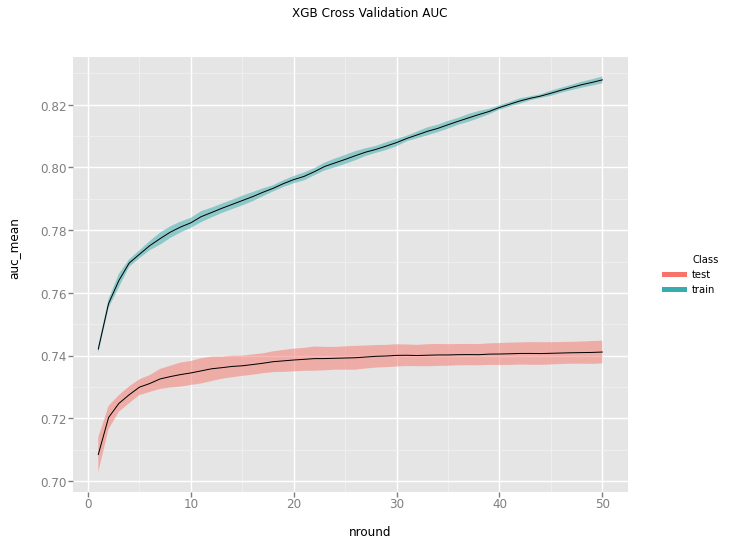

In [7]:
# save CV figures
p1 = xgb_plot(best_mdcv,'auc')
p1.save('plots/CV_auc_1920_2_3.png')

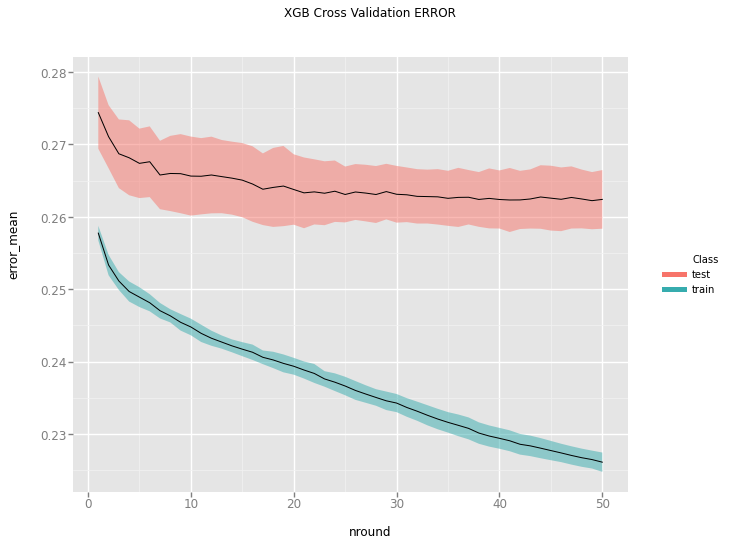

In [8]:
p2 =xgb_plot(best_mdcv,'error') 
p2.save('plots/CV_error_1920_2_3.png')

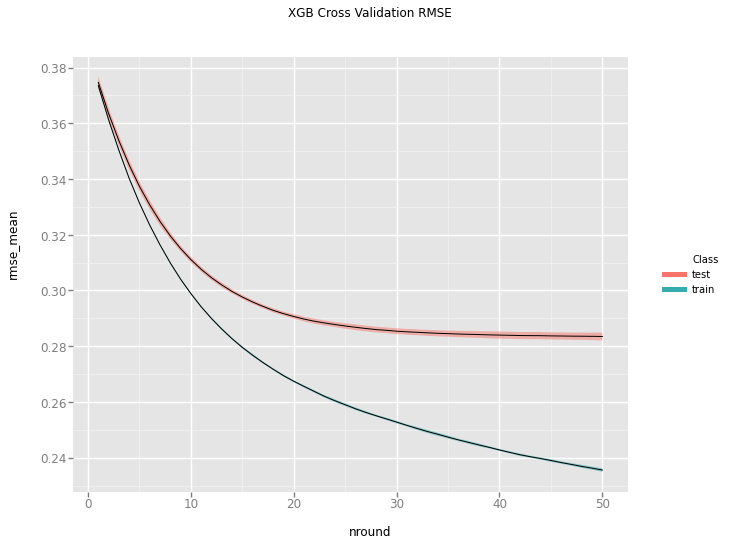

In [9]:
p3 = xgb_plot(best_mdcv,'rmse')
p3.save('plots/CV_rmse_1920_2_3.png')

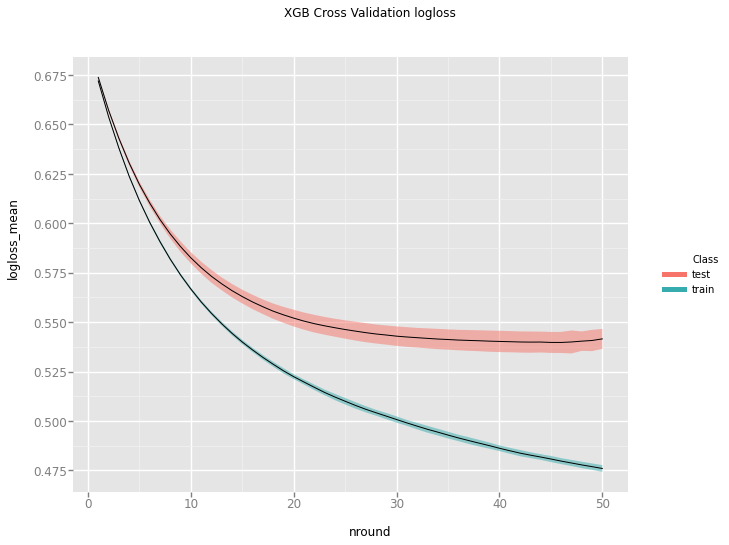

In [10]:
p4 = xgb_plot(best_mdcv,'logloss')
p4.save('plots/CV_logloss_1920_2_3.png')

In [11]:
#train best model
nround = best_round
md_1 = xgb.train(best_param, dtrain, num_boost_round=nround)

# prediction with unweighted rmse
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error


dtest = xgb.DMatrix(X_test, feature_names=list(X_test), weight = test_weights)
preds = md_1.predict(dtest)
print(np.sqrt(mean_squared_error(y_test, preds)))

0.2902387483219678


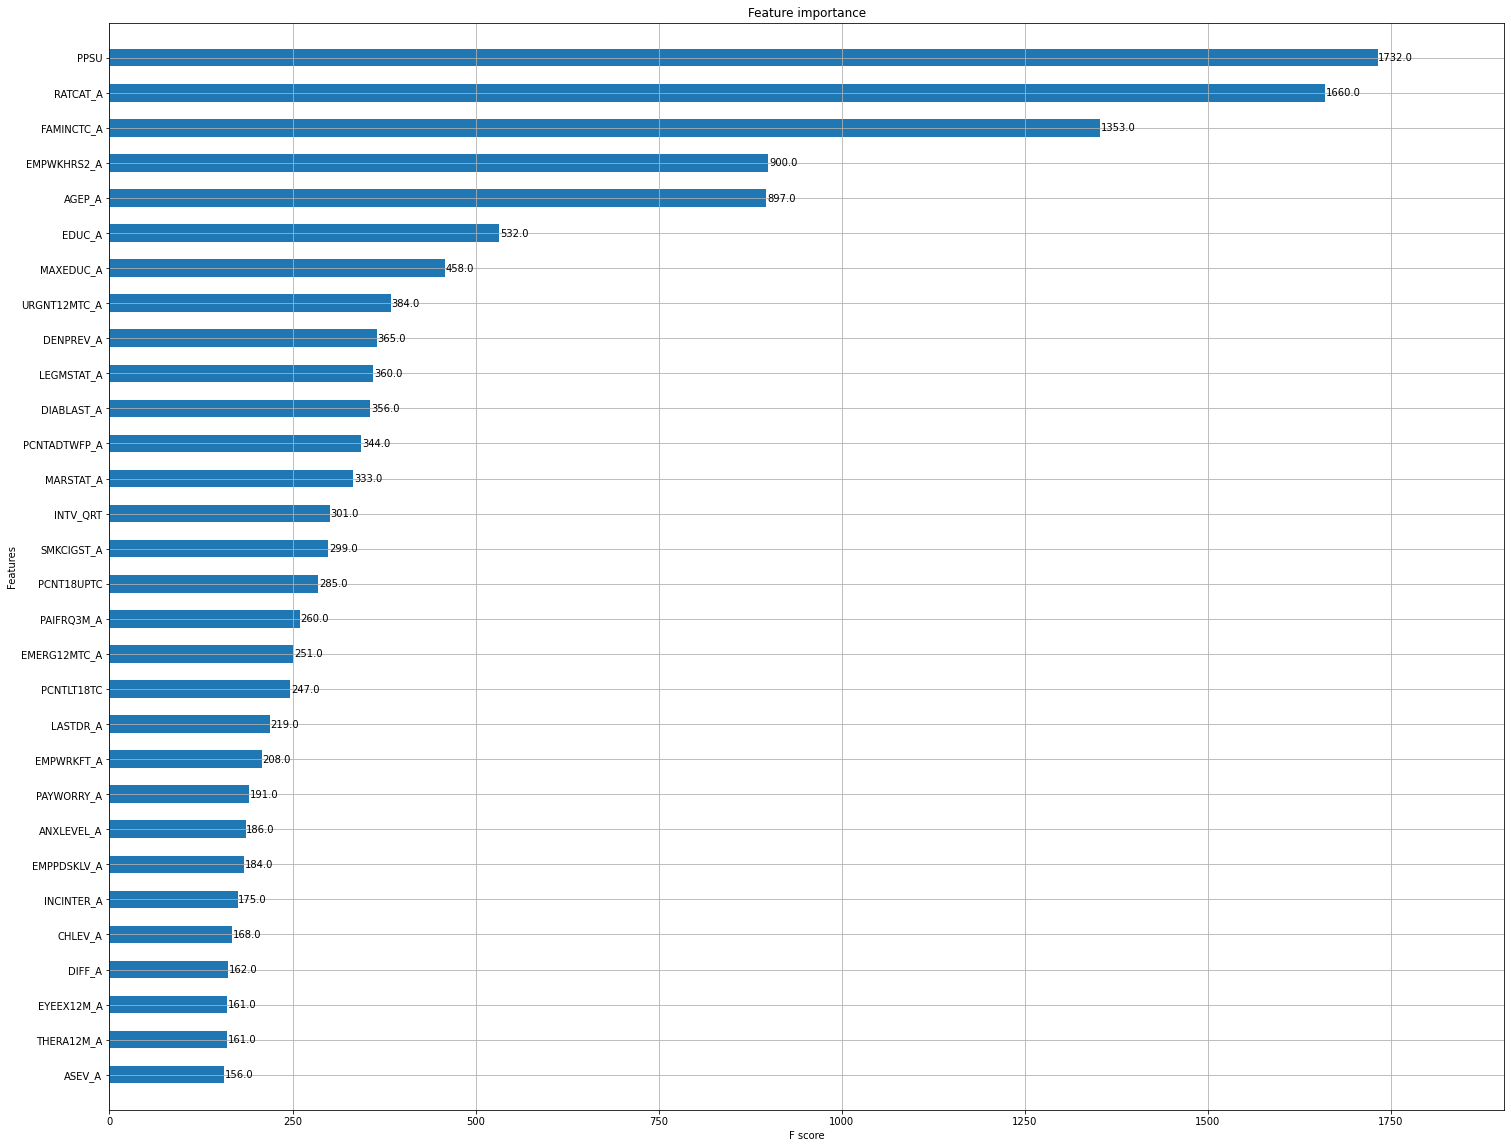

In [12]:
# plot figure of importance (first 30)
ax = xgb.plot_importance(md_1, height=0.5,max_num_features = 30)
fig = ax.figure
fig.set_size_inches(25,20) 
plt.savefig('plots/Feature_importance_1920_2_3.png')
plt.show()

In [13]:
## Part II:
## 2019's model performance on 2020's data
# after using different methods of imputation and feature selection, we decide to use 2.3
# then use 2019 data as a training data, train a model to fit for 2020
df_19 = pd.read_csv("data/data_19_2_3_fluboth.csv")
df_20 = pd.read_csv("data/data_20_2_0_fluboth.csv")

In [14]:
y_train = df_19.Y
y_test = df_20.Y
train_weights = df_19['Weight']
test_weights = df_20['Weight']
X_train = df_19.drop(['Y', 'Unnamed: 0', 'Weight'],axis=1)
X_test = df_20.drop(['Y', 'Unnamed: 0', 'Weight'],axis=1)

dtrain = xgb.DMatrix(X_train, y_train, feature_names = list(X_train),weight = train_weights)                 

In [15]:
best_param, best_mdcv,best_round = parameter_tuning(dtrain, 200)

best_round = 30
best_param : ------------------------------
{'max_depth': 5, 'eta': 0.13331972309684736, 'gamma': 0.2, 'subsample': 0.7472258413950086, 'colsample_bytree': 0.7, 'min_child_weight': 4, 'max_delta_step': 2, 'nthread': 4}
0.2860336
    train-auc-mean  train-auc-std  train-rmse-mean  train-rmse-std  \
0         0.704526       0.002172         0.368432        0.000763   
1         0.717254       0.001916         0.351593        0.000670   
2         0.725664       0.003042         0.337916        0.000674   
3         0.730565       0.002970         0.326905        0.000661   
4         0.733913       0.001429         0.318261        0.000822   
5         0.735313       0.001289         0.311442        0.000792   
6         0.737706       0.001719         0.305810        0.000853   
7         0.739073       0.001499         0.301296        0.000792   
8         0.740381       0.001263         0.297639        0.000776   
9         0.742075       0.001162         0.294557     

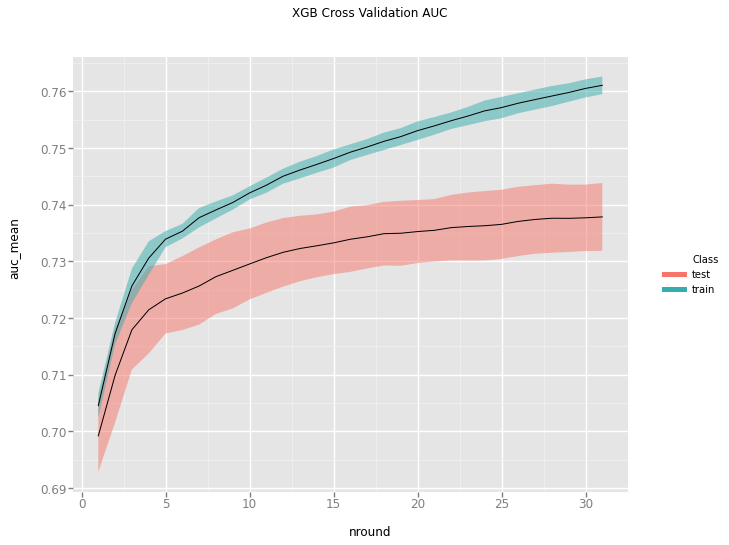

In [16]:
# save CV figures
p1 = xgb_plot(best_mdcv,'auc')
p1.save('plots/CV_auc_19_2_3.png')

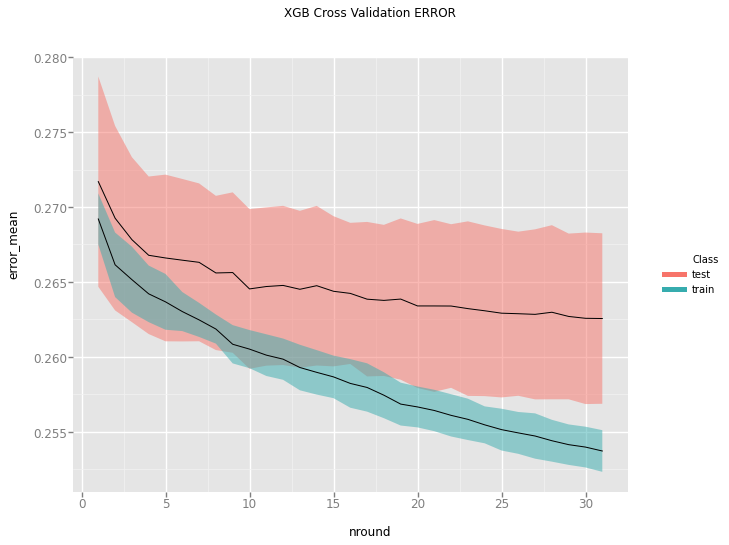

In [17]:
p2 =xgb_plot(best_mdcv,'error') 
p2.save('plots/CV_error_19_2_3.png')

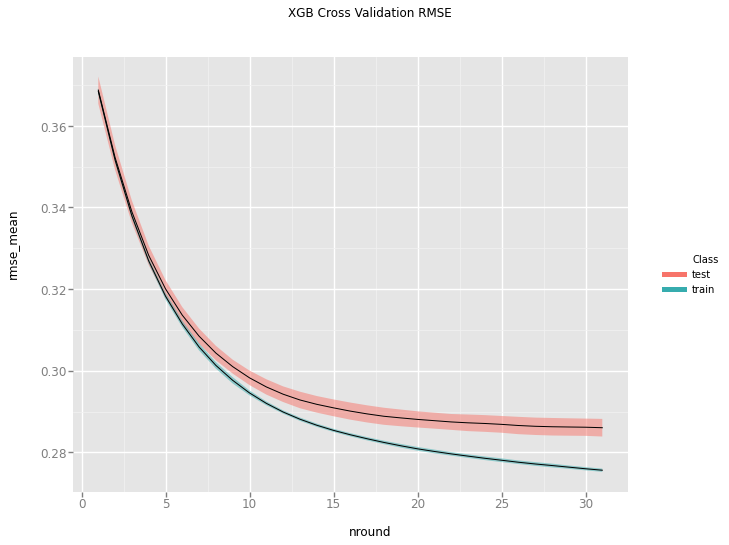

In [18]:
p3 = xgb_plot(best_mdcv,'rmse')
p3.save('plots/CV_rmse_19_2_3.png')

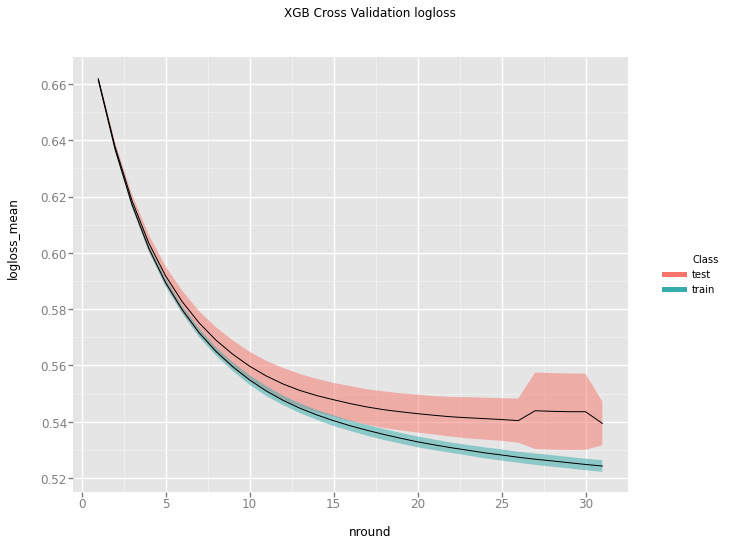

In [19]:
p4 = xgb_plot(best_mdcv,'logloss')
p4.save('plots/CV_logloss_19_2_3.png')

In [20]:
#train best model
nroud = best_round
md_1 = xgb.train(best_param, dtrain, num_boost_round=nround)

# prediction on 2020's data
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error


dtest = xgb.DMatrix(X_test, feature_names=list(X_test), weight = test_weights)
preds = md_1.predict(dtest)
print(np.sqrt(mean_squared_error(y_test, preds)))

0.29278385343730967


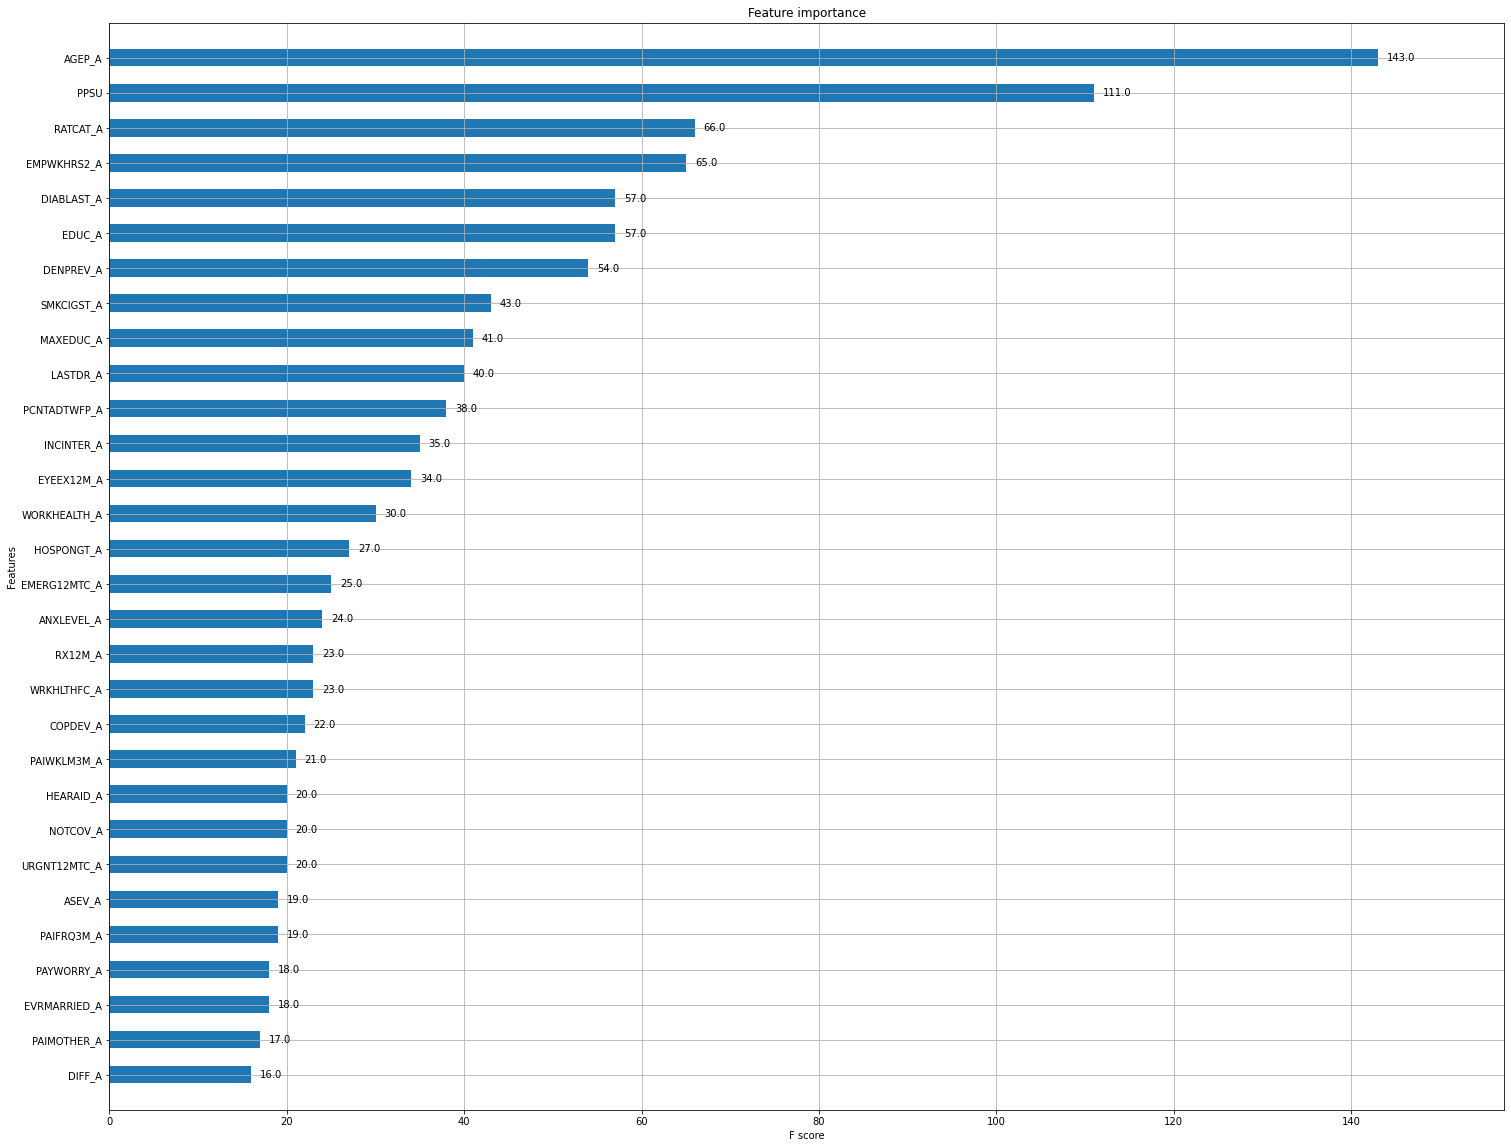

In [21]:
# plot figure of importance (first 30)
ax = xgb.plot_importance(md_1, height=0.5,max_num_features = 30)
fig = ax.figure
fig.set_size_inches(25,20) 
plt.savefig('plots/Feature_importance_19_2_3.png')
plt.show()

In [32]:
## Part III:
## 19 and 20's flu 1 as a classifier variable, to predict 19 and 20's flu 2
df_19_1 = pd.read_csv("data/data_1920_2_3_flu1.csv")
df_20_2 = pd.read_csv("data/data_1920_2_0_flu2.csv")
y_train = df_19_1.Y
y_test = df_20_2.Y
train_weights = df_19_1['Weight']
test_weights = df_20_2['Weight']
X_train = df_19_1.drop(['Y', 'Unnamed: 0', 'Weight'],axis=1)
X_test = df_20_2.drop(['Y', 'Unnamed: 0', 'Weight'],axis=1)

dtrain = xgb.DMatrix(X_train, y_train, feature_names = list(X_train),weight = train_weights)  

In [23]:
# randomsearch parameter tuning
# max_depth,eta, gamma, etc are randomly choosed and select a best params with lowest rmse

def parameter_tuning(dtrain, rounds):
    best_param = list()
    best_merror = np.Inf
    best_merror_index = 0
    depth = [np.random.randint(4,10) for i in range(rounds)]
    eta = [np.random.uniform(.01, .3) for i in range(rounds)]
    subsample = [np.random.uniform(.6, .9) for i in range(rounds)]
    min_child_weight = [np.random.randint(1,20) for i in range(rounds)]
    max_delta_step = [np.random.randint(1,11) for i in range(rounds)]
    gamma = 0.2
    colsample_bytree = 0.7
    for iter in range(rounds):
        param = {'objective':"multi:softmax", 
                 'num_class':2,
              'max_depth' : depth[iter],         
              'eta' : eta[iter],            
              'gamma' : gamma,         
              'subsample' : subsample[iter],             
              'colsample_bytree' : colsample_bytree, 
              'min_child_weight' : min_child_weight[iter],
              'max_delta_step' : max_delta_step[iter],
              'nthread': 4}
        cv_nround = 50                                   
        cv_nfold = 5                                     
        mdcv = xgb.cv(params = param, dtrain=dtrain,metrics=["merror","mlogloss"],
                    nfold=cv_nfold, num_boost_round=cv_nround, verbose_eval = None,
                    early_stopping_rounds=8, maximize=False)

        min_merror = min(mdcv['test-merror-mean'])
        min_merror_index = mdcv.index[mdcv['test-merror-mean'] == min(mdcv['test-merror-mean'])][0]
        if min_merror < best_merror:
            best_merror = min_merror
            best_merror_index = min_merror_index
            best_param = param
            best_mdcv = mdcv

    nround = best_merror_index
    print('best_round = %d'% nround)
    print('best_param : ------------------------------')
    print(best_param) 
    print(best_merror)
    print(best_mdcv)
    return best_param, best_mdcv, nround

In [24]:
best_param, best_mdcv,best_round = parameter_tuning(dtrain, 200)

best_round = 34
best_param : ------------------------------
{'objective': 'multi:softmax', 'num_class': 2, 'max_depth': 6, 'eta': 0.21889645344483818, 'gamma': 0.2, 'subsample': 0.8841962227472404, 'colsample_bytree': 0.7, 'min_child_weight': 17, 'max_delta_step': 1, 'nthread': 4}
0.30527
    train-merror-mean  train-merror-std  train-mlogloss-mean  \
0            0.319516          0.002965             0.661181   
1            0.312244          0.002568             0.638185   
2            0.308993          0.002252             0.621374   
3            0.306257          0.002359             0.609013   
4            0.304004          0.002261             0.599320   
5            0.301891          0.002651             0.591549   
6            0.300105          0.001890             0.585397   
7            0.297694          0.001977             0.580217   
8            0.296567          0.001715             0.575516   
9            0.294885          0.002276             0.571507   
10    

In [25]:
# function to plot xgb evaluation

def xgb_plot_cat(input,output):
    history=input
    train_history=history.iloc[:,0:4].assign(id=[i+1 for i in history.index])
    train_history['Class'] = 'train'
    test_history=history.iloc[:,4:8].assign(id=[i+1 for i in history.index])
    test_history['Class'] = 'test'
    train_history.columns = ["merror_mean","merror_std","mlogloss_mean","mlogloss_std","id","Class"]
    test_history.columns = ["merror_mean","merror_std","mlogloss_mean","mlogloss_std","id","Class"]
  
    his=pd.concat([train_history,test_history])
  
    if output=="merror":
        his['y_min_merror'] = his['merror_mean']-his['merror_std']
        his['y_man_merror'] = his['merror_mean']+his['merror_std']

        merror=ggplot(his,aes(x='id', y='merror_mean', ymin='y_min_merror', ymax='y_man_merror',fill='Class'))+\
          geom_line()+\
          geom_ribbon(alpha=0.5)+\
          labs(x="nround",y='',title = "XGB Cross Validation merror")
        return(merror)
    
    if output=="mlogloss":
        his['y_min_mlogloss'] = his['mlogloss_mean']-his['mlogloss_std']
        his['y_man_mlogloss'] = his['mlogloss_mean']+his['mlogloss_std']

        mlogloss=ggplot(his,aes(x='id', y='mlogloss_mean', ymin='y_min_mlogloss', ymax='y_man_mlogloss',fill='Class'))+\
          geom_line()+\
          geom_ribbon(alpha=0.5)+\
          labs(x="nround",y='',title = "XGB Cross Validation mlogloss")
        return(mlogloss)

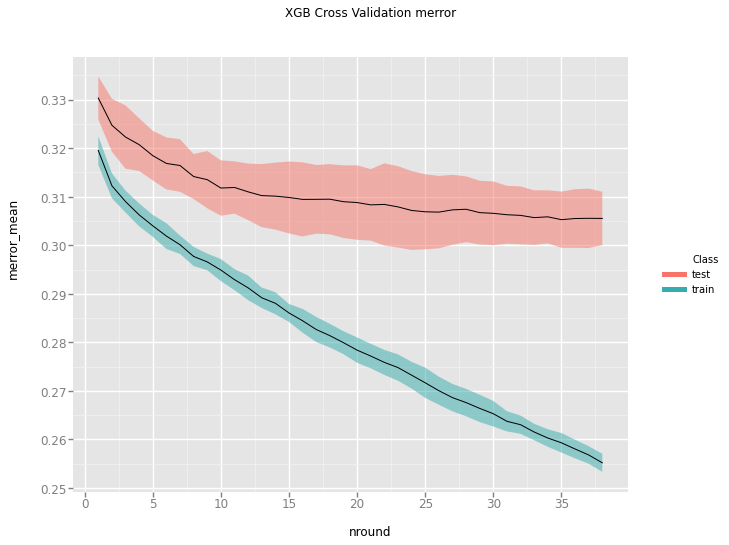

In [26]:
# save CV figures
p1 = xgb_plot_cat(best_mdcv,'merror')
p1.save('plots/CV_merror_1920_2_3_flu1.png')

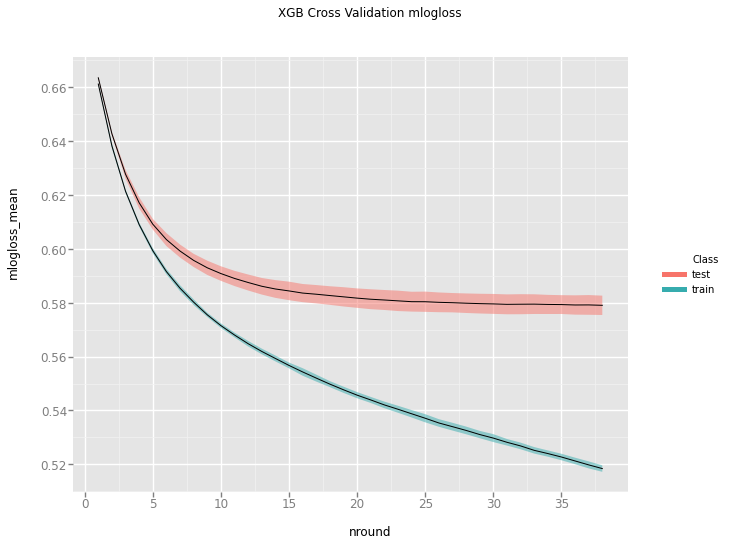

In [27]:
p2 = xgb_plot_cat(best_mdcv,'mlogloss')
p2.save('plots/CV_mloloss_1920_2_3_flu1.png')

[17:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


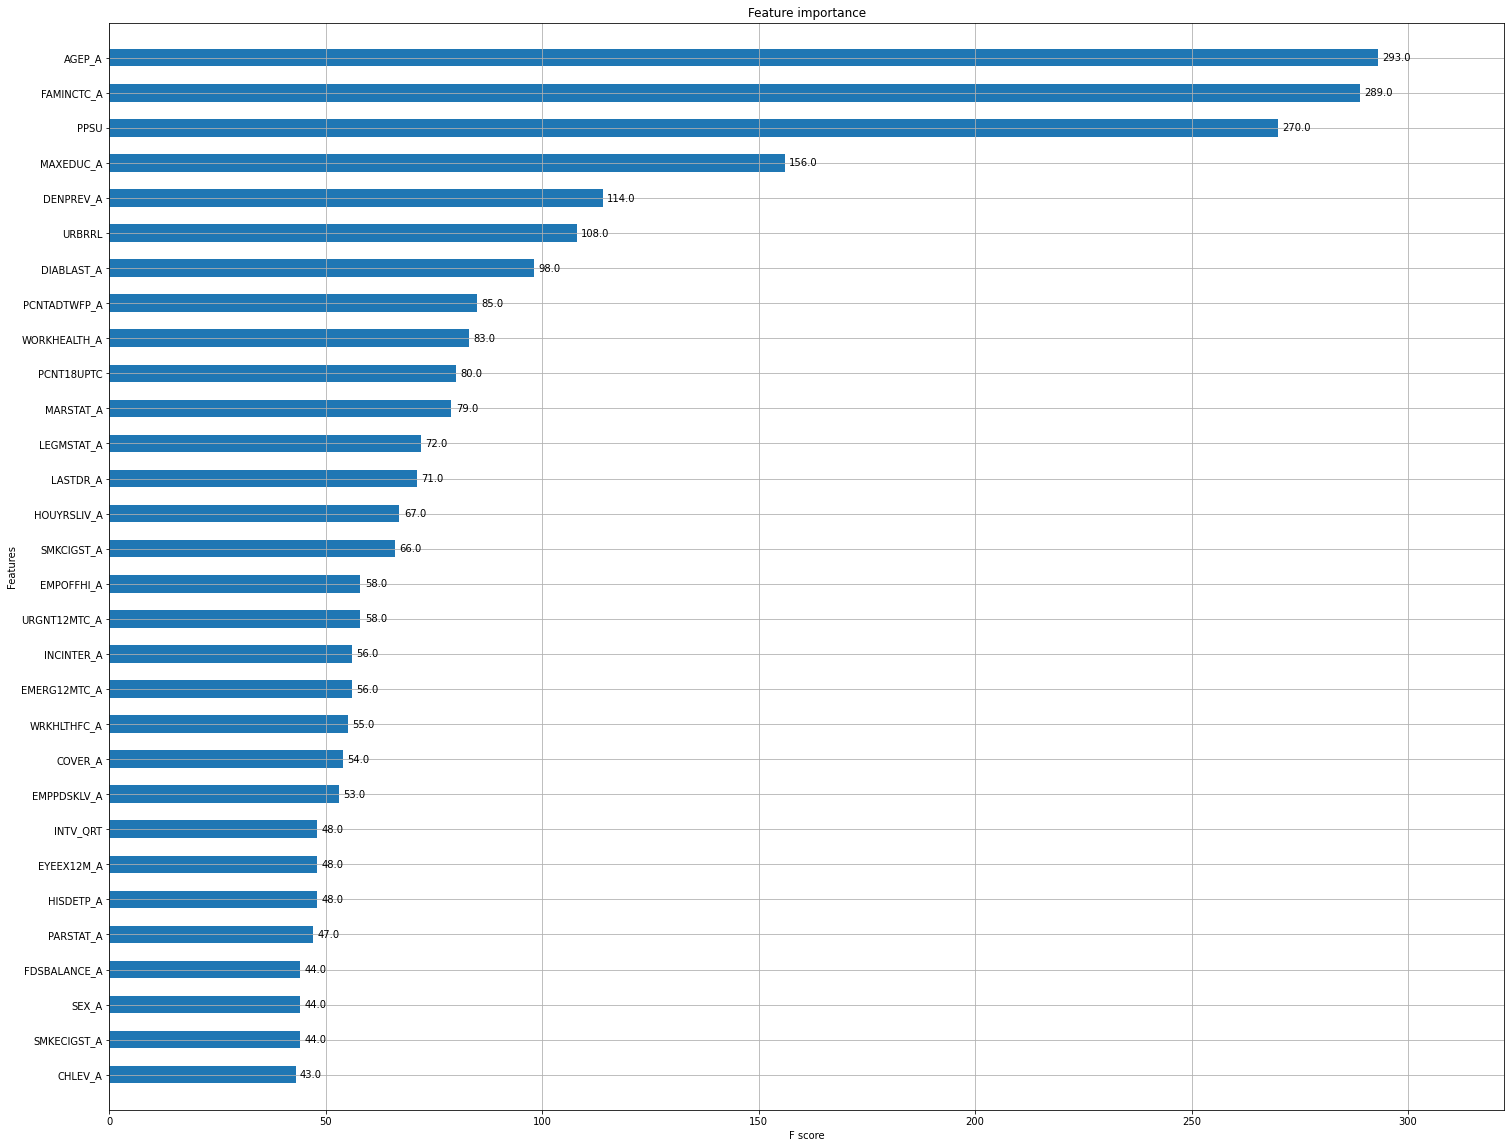

In [33]:
# plot figure of importance (first 30)
md = xgb.train(best_param, dtrain, num_boost_round=best_round)
ax = xgb.plot_importance(md, height=0.5,max_num_features = 30)
fig = ax.figure
fig.set_size_inches(25,20) 
plt.savefig('plots/Feature_importance_1920_2_3_flu1.png')
plt.show()
